**Notebook contains following sections:**


*   EDA of raw data
*   Data Cleansing
*   Preprocessing
*   Creating word embeddings
*   Model creation
*   Setting up train and test dataloader
*   Defining training and evaluation setup
*   Model training
*   Model evaluation
*   Generate submission









In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from textblob import Word
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import gensim.downloader
import pickle
from torch.utils.data import Dataset
import torch
from torch.nn import Module
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Basic EDA of raw train data**



In [3]:
train_path = '/content/drive/My Drive/fake-news/train.csv'
test_path = '/content/drive/My Drive/fake-news/test.csv'
submission_path = '/content/drive/My Drive/fake-news/'

In [4]:
df_raw = pd.read_csv(train_path)

In [5]:
df_raw.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
df_raw.shape

(20800, 5)

In [7]:
pd.isnull(df_raw).any()

id        False
title      True
author     True
text       True
label     False
dtype: bool

There are some NULLs in the data

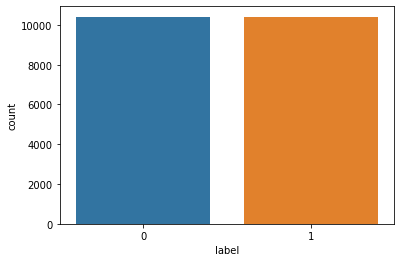

In [8]:
grouped_data = df_raw.groupby("label")["id"].count().reset_index()
sns.barplot(x="label", y="id", data=grouped_data)
plt.ylabel("count")
plt.show()

Classes look balanced

In [9]:
grouped_data = df_raw.groupby("author")[["id","label"]].agg({"id":"count","label":"sum"}).reset_index()

In [10]:
grouped_data[grouped_data.label==grouped_data.id].sort_values(by="label",ascending=False)

,author,id,label
3929,admin,193,193
2939,Pakalert,86,86
1111,Eddy Lavine,85,85
3518,Starkman,84,84
1376,Gillian,82,82
...,...,...,...
1656,James Staten,1,1
1652,James Richard Tyrer,1,1
1647,James Miller,1,1
1646,James Michael,1,1


Some of the authors have 100% fake news. Author can be good predictor.

**Data Cleansing**

In [11]:
df_raw.title.fillna("NA", inplace=True)
df_raw.text.fillna("NA", inplace=True)
df_raw.author.fillna("NA", inplace=True)

df_raw['title_length'] = df_raw.title.apply(lambda x: len(x.split()) if x != "NA" else 0)
df_raw['text_length'] = df_raw.text.apply(lambda x: len(x.split()) if x != "NA" else 0)

In [12]:
df_raw[["text_length","title_length"]].describe([0.05,0.95])

,text_length,title_length
count,20800.000000,20800.000000
mean,758.882548,12.087500
std,869.332866,4.514065
min,0.000000,0.000000
5%,40.000000,5.000000
50%,554.000000,12.000000
95%,1871.000000,18.000000
max,24234.000000,72.000000


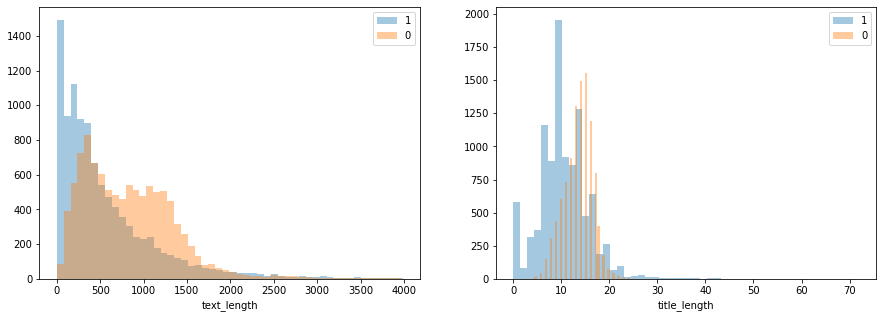

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.distplot(df_raw[(df_raw.text_length<4000) & (df_raw.label==1)]["text_length"],ax=ax[0],label="1", kde=False)
sns.distplot(df_raw[(df_raw.text_length<4000) & (df_raw.label==0)]["text_length"],ax=ax[0],label="0", kde=False)
ax[0].legend()

sns.distplot(df_raw[(df_raw.text_length<4000) & (df_raw.label==1)]["title_length"],ax=ax[1],label="1", kde=False)
sns.distplot(df_raw[(df_raw.text_length<4000) & (df_raw.label==0)]["title_length"],ax=ax[1],label="0",kde=False)
ax[1].legend()

plt.show()

Length of the title and title also seem to be correlating with the label. Smaller text and titles are more fake

In [32]:
# Hyper parameters for the model

VOCAB_SIZE = 10000
MAX_LEN_TEXT = 500
MAX_LEN_TITLE = 50
VEC_SIZE = 300
BATCH_SIZE = 64
NUM_CLASSES = 1
HIDDEN_DIM_TITLE = 64
HIDDEN_DIM_TEXT = 128
LEARNING_RATE = 1e-3
EPOCHS = 30

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print (device)

cuda


In [62]:
df_train, df_test = train_test_split(df_raw[["id","author","title","text","label"]],test_size=0.1,random_state=1,stratify=df_raw["label"])

df_train, df_val = train_test_split(df_train[["id","author","title","text","label"]],test_size=0.1,random_state=1,stratify=df_train["label"])

**Preprocessing**

In [17]:
# class to perform all the preprocessing steps

class Preprocessing():
  def __init__(self, tokenizer, scaler, sequence, author_fake_ratio=None):
    self.tokenizer = tokenizer
    self.author_fake_ratio = author_fake_ratio
    self.scaler = scaler
    self.sequence = sequence

  def _text_processing(self, df):
    df['title_length'] = df.title.apply(lambda x: len(x.split()) if x != "NA" else 0)
    df['text_length'] = df.text.apply(lambda x: len(x.split()) if x != "NA" else 0)

    df['title'] = df.title.apply(lambda x:
                                          " ".join(Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize() 
                                          for w in x.split() 
                                          if Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize() not in stop_words and len(Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize()) >= 2
                                          )
                                          )

    df['author'] = df.author.apply(lambda x:
                                            " ".join(Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize() 
                                            for w in x.split() 
                                            if len(Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize()) >= 2
                                            )
                                            )

    df["author"] = df.apply(lambda row: "NA" if len(row["author"])<2 else row["author"],axis=1)

    df['text'] = df.text.apply(lambda x:
                                        " ".join(Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize() 
                                        for w in x.split() 
                                        if Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize() not in stop_words and len(Word(re.sub(r'[^a-zA-Z]',' ',w).lower()).lemmatize()) >= 2
                                        )
                                        )
    return df

  def _data_cleansing(self, df ):
    df.title.fillna("NA", inplace=True)
    df.text.fillna("NA", inplace=True)
    df.author.fillna("NA", inplace=True)

    return df

  def _tokenize(self, df, stage="train"):
    X_text = df["text"]
    X_title = df["author"] + " " + df["title"]
    X_length = np.array(df[["title_length","text_length"]],"float")
    X_id = df["id"]

    if stage == "train":
      self.tokenizer.fit_on_texts(np.concatenate([X_text,X_title], axis = 0))
      self.scaler.fit(X_length)

      X_length = self.scaler.transform(X_length)
      X_text_seq = self.tokenizer.texts_to_sequences(X_text)
      X_title_seq = self.tokenizer.texts_to_sequences(X_title)
      X_text_seq = self.sequence.pad_sequences(X_text_seq, maxlen=MAX_LEN_TEXT,padding="post",truncating="post")
      X_title_seq = self.sequence.pad_sequences(X_title_seq, maxlen=MAX_LEN_TITLE,padding="post",truncating="post")
      X_seq = np.concatenate([X_text_seq, X_title_seq, X_length], axis=1)

    else:
      X_length = self.scaler.transform(X_length)
      X_text_seq = self.tokenizer.texts_to_sequences(X_text)
      X_title_seq = self.tokenizer.texts_to_sequences(X_title)
      X_text_seq = self.sequence.pad_sequences(X_text_seq, maxlen=MAX_LEN_TEXT,padding="post",truncating="post")
      X_title_seq = self.sequence.pad_sequences(X_title_seq, maxlen=MAX_LEN_TITLE,padding="post",truncating="post")
      X_seq = np.concatenate([X_text_seq, X_title_seq, X_length], axis=1)

    return X_seq    



  def process(self, df, stage):
    ids = df["id"]
    df = self._data_cleansing(df)
    df = self._text_processing(df)
    
    X = self._tokenize(df, stage)

    if stage == "test":
      return X, ids

    else:
      y = df["label"]
      return X, y

In [18]:
# tokenizer for text columns
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

# standard scaler for numeric features
scaler = StandardScaler()

preprocessor = Preprocessing(tokenizer, scaler, sequence)

In [64]:
X_train, y_train = preprocessor.process(df_train, "train")
X_val, y_val = preprocessor.process(df_val, "val")
X_test, y_test = preprocessor.process(df_test, "val")

In [65]:
# converting to tensors

y_train = torch.from_numpy(y_train.to_numpy().astype('float')).float()
y_val = torch.from_numpy(y_val.to_numpy().astype('float')).float()

X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()

y_test = torch.from_numpy(y_test.to_numpy().astype('float')).float()

X_test = torch.from_numpy(X_test).float()

**Word Embeddings**

In [22]:
# w2v_vectors = gensim.downloader.load('word2vec-google-news-300')
embed_path = "/content/drive/My Drive/fake-news/w2v_vectors.pickle"

# with open(embed_path, 'wb') as f:
#    pickle.dump(w2v_vectors, f)

f = open (embed_path, "rb")
w2v_vectors = pickle.load(f)

In [23]:
w2v_matrix = np.zeros((len(tokenizer.word_index)+1, VEC_SIZE),"float")

for idx, word in tokenizer.index_word.items():
  try:
    w2v_matrix[idx] = w2v_vectors[word]
  except KeyError:
    w2v_matrix[idx] = np.random.normal(scale=0.6, size=(VEC_SIZE, ))

**Model Creation**

In [47]:
class Model(Module):
  def __init__(self, w2v_matrix, hidden_dim_text, hidden_dim_title, num_classes, device):
    super(Model, self).__init__()
    self.num_embeddings, self.embed_dimensions = w2v_matrix.shape
    self.hidden_dim_text = hidden_dim_text
    self.hidden_dim_title = hidden_dim_title
    self.num_classes = num_classes
    self.device = device

    self.embedding = nn.Embedding(self.num_embeddings, self.embed_dimensions, padding_idx=0)
    self.embedding.weight = nn.Parameter(torch.Tensor(w2v_matrix))
    self.embedding.weight.requires_grad = False

    self.lstm_text = torch.nn.LSTM(input_size=self.embed_dimensions, hidden_size=self.hidden_dim_text, bidirectional=False, batch_first=True)

    self.lstm_title = torch.nn.LSTM(input_size=self.embed_dimensions, hidden_size=self.hidden_dim_title, bidirectional=False, batch_first=True)

    self.lr1 = nn.Linear(2, 1)

    self.fc1 = nn.Linear(self.hidden_dim_text + self.hidden_dim_title + 1, self.num_classes)

    self.drop = nn.Dropout(0.4)

  def forward(self, x):
    h0_text, a0_text = torch.zeros(1,x.shape[0],self.hidden_dim_text), torch.zeros(1,x.shape[0],self.hidden_dim_text)
    h0_title, a0_title = torch.zeros(1,x.shape[0],self.hidden_dim_title), torch.zeros(1,x.shape[0],self.hidden_dim_title)

    h0_text = h0_text.to(device)
    a0_text = a0_text.to(device)
    h0_title = h0_title.to(device)
    a0_title = a0_title.to(device)

    x_linear = x[:,-2:]

    x = self.embedding(x[:,:-2].int())

    x_text, (hn_text, an_text) = self.lstm_text(x[:,:MAX_LEN_TEXT], (h0_text, a0_text))
    x_title, (hn_title, an_title) = self.lstm_title(x[:,MAX_LEN_TEXT:], (h0_title, a0_title))
    
    x_text = x_text[:,-1,:]
    x_title = x_title[:,-1,:]

    x = torch.cat((x_text, x_title), 1)

    x = self.drop(x)

    x_linear = nn.ReLU()(self.lr1(x_linear))

    x = torch.cat((x, x_linear), 1)
   
    x = self.fc1(x).view(x.shape[0],self.num_classes)

    return x.squeeze(1)

In [74]:
# model object
classifier = Model(w2v_matrix, HIDDEN_DIM_TEXT, HIDDEN_DIM_TITLE, NUM_CLASSES, device).to(device)

# loss function - binary cross entropy
criterion = torch.nn.BCEWithLogitsLoss().to(device)

# Adam optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

# Learning rate decay scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

**Setting up train and test dataloader**

In [26]:
# Training dataset for training
class Train_Dataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        return self.X[index],self.y[index]

# Test dataset
class Test_Dataset(Dataset):
    def __init__(self, X, id):
        self.X = X
        self.id = id

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        return self.X[index], self.id[index]

In [35]:
train_dataset = Train_Dataset(X_train,y_train)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Train_Dataset(X_val,y_val)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

**Defining training and evaluation setup**

In [28]:
def train(model, test_loader, device, criterion, optimizer):
    model.train()
    train_loss_epoch = 0
    correct = 0
    for idx,(data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        y_hat = model(data)
        train_loss_batch = criterion(y_hat, target)
        train_loss_epoch += train_loss_batch.data.item()

        train_loss_batch.backward()
        optimizer.step()

        y_hat[y_hat>=0.5] = 1
        y_hat[y_hat<0.5] = 0

        correct += y_hat.eq(target.view_as(y_hat)).sum().item()

    return train_loss_epoch/len(train_loader), correct/len(train_loader.dataset)


def val(model, val_loader, device, criterion):
    val_loss_epoch = 0
    correct = 0
    model.eval()
    with torch.no_grad():
      for idx,(data, target) in enumerate(val_loader):

          data = data.to(device)
          target = target.to(device)
          
          y_hat = model(data)
          val_loss_batch = criterion(y_hat, target)
          val_loss_epoch += val_loss_batch.data.item()

          y_hat[y_hat>=0.5] = 1
          y_hat[y_hat<0.5] = 0

          correct += y_hat.eq(target.view_as(y_hat)).sum().item()

    return val_loss_epoch/len(val_loader), correct/len(val_loader.dataset)

In [77]:
def plot_loss(metric, train, val):

    plt.plot(train)
    plt.plot(val)
    plt.title("model_{}".format(metric))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    if metric == "loss":
      plt.legend(['train', 'val'], loc='upper right')
    else:
      plt.legend(['train', 'val'], loc='lower right')

    plt.show()


def predict(model, X, device):
  model.eval()
  with torch.no_grad():
    X = X.to(device)
    y_pred = model(X)
    y_pred = torch.sigmoid(y_pred)

    return y_pred.cpu()


def eval(model, y_true, y_pred, thres):
  y_pred[y_pred>=thres] = 1
  y_pred[y_pred<thres] = 0

  print ("\nConfusion Matrix\n")
  print (confusion_matrix(y_true, y_pred))

  print ("\nClassification Report\n")
  print (classification_report(y_true, y_pred))

  print ("\nROC_AUC\n")
  print (roc_auc_score(y_true, y_pred))

  print ("\nROC Curve\n")
  fpr, tpr,_ = roc_curve(y_true,y_pred)

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(fpr, tpr,label='Train')
  ax.set_xlabel('FPR', fontsize=12)
  ax.set_ylabel('TPR', fontsize=12)

  plt.show()

**Model training**

In [49]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
                    
for i in range(EPOCHS):
    
    train_loss_epoch, train_acc_epoch = train(classifier, train_loader, device, criterion, optimizer)
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)

    val_loss_epoch, val_acc_epoch = val(classifier, val_loader, device, criterion)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    # scheduler.step()

    if i%2==0:
        print ("Learning rate: ", scheduler.state_dict()["_last_lr"])
        print ("Epoch:{} Train Loss:{:.4f}  Val Loss:{:.4f} Train Acc:{:.4f}  Val Acc:{:.4f}".format(i,train_loss[-1],val_loss[-1],train_acc[-1],val_acc[-1]))

Learning rate:  [0.001]
Epoch:0 Train Loss:0.6817  Val Loss:0.6745 Train Acc:0.5037  Val Acc:0.4995
Learning rate:  [0.001]
Epoch:2 Train Loss:0.6408  Val Loss:0.6338 Train Acc:0.5880  Val Acc:0.5994
Learning rate:  [0.001]
Epoch:4 Train Loss:0.6132  Val Loss:0.6081 Train Acc:0.6560  Val Acc:0.6576
Learning rate:  [0.001]
Epoch:6 Train Loss:0.5893  Val Loss:0.4076 Train Acc:0.6774  Val Acc:0.8397
Learning rate:  [0.001]
Epoch:8 Train Loss:0.0893  Val Loss:0.0716 Train Acc:0.9701  Val Acc:0.9749
Learning rate:  [0.001]
Epoch:10 Train Loss:0.0498  Val Loss:0.0641 Train Acc:0.9855  Val Acc:0.9856
Learning rate:  [0.001]
Epoch:12 Train Loss:0.0379  Val Loss:0.0660 Train Acc:0.9900  Val Acc:0.9856
Learning rate:  [0.001]
Epoch:14 Train Loss:0.0304  Val Loss:0.0590 Train Acc:0.9919  Val Acc:0.9818
Learning rate:  [0.001]
Epoch:16 Train Loss:0.0265  Val Loss:0.0486 Train Acc:0.9934  Val Acc:0.9866
Learning rate:  [0.001]
Epoch:18 Train Loss:0.0242  Val Loss:0.0624 Train Acc:0.9947  Val Acc:0.

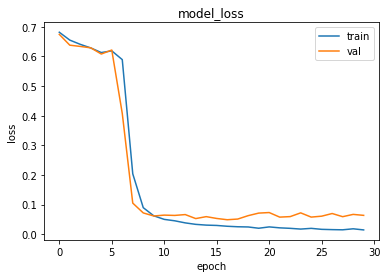

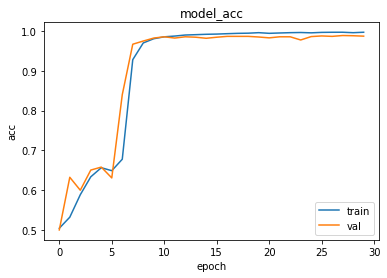

In [51]:
plot_loss("loss", train_loss, val_loss)
plot_loss("acc", train_acc, val_acc)

**Model evaluation**


Confusion Matrix

[[1029   10]
 [  17 1024]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1039
         1.0       0.99      0.98      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080


ROC_AUC

0.9870224547175063

ROC Curve



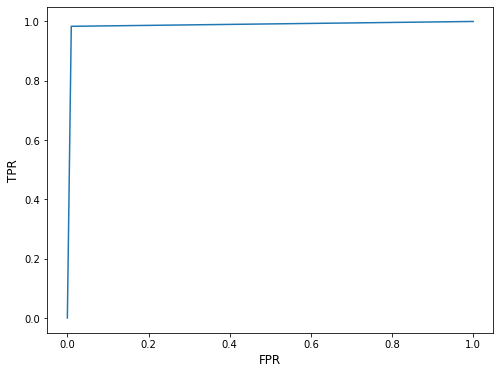

In [78]:
y_pred_test = predict(classifier, X_test, device)

eval(classifier, y_test, y_pred_test, 0.5)

**Generate Submission**

In [52]:
class Submission():
  def __init__(self, thres, device, test_loader):
    self.thres = thres
    self.device = device
    self.data_loader = test_loader

  def _generate_df(self, id, y):

    df = pd.DataFrame(zip(id, y), columns=["id","label"])
    return df

  def test(self, model):

    model.eval()
    test_ids = []
    test_pred = []
    with torch.no_grad():
      for idx,(data, id) in enumerate(self.data_loader):

          data = data.to(device)
          
          y_hat = model(data)

          y_hat[y_hat>=self.thres] = 1
          y_hat[y_hat<self.thres] = 0

          test_ids.extend(id.cpu().numpy())
          test_pred.extend(y_hat.cpu().int().numpy())

    submission = self._generate_df(test_ids, test_pred)

    return submission

In [53]:
df_submit = pd.read_csv(test_path)

X_submit, ids_submit = preprocessor.process(df_submit, "test")

X_submit = torch.from_numpy(X_submit).float()

submit_dataset = Test_Dataset(X_submit, ids_submit)

submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=BATCH_SIZE)

In [54]:
submission = Submission(0.5, device, submit_loader)

df_submission = submission.test(classifier)

df_submission.to_csv(submission_path + "submit.csv", index=False)

In [55]:
df_submission.shape

(5200, 2)

In [56]:
df_submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
